In [1]:
# ------------------------------
# FIG 1: PERSUASIVE IMPACT WITH RESPECT TO CONTROL

# This code is used to generate the model and figure for figure 1 in the main text
# ------------------------------

# Import libraries
import pandas as pd
import numpy as np
import statsmodels as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# Read in data
df = pd.read_csv('../data/final_dataset.csv')

# Reshape the dataframe
reshaped_df = df.melt(id_vars='prolific_ID', 
                      value_vars=['dv_response_mean_vax', 'dv_response_mean_dep', 'dv_response_mean_elec'], 
                      var_name='response_type', 
                      value_name='dv_response_mean')

# Map additional data columns to the reshaped dataframe
reshaped_df['party'] = reshaped_df['prolific_ID'].map(df.set_index('prolific_ID')['party'])
reshaped_df['aligned'] = reshaped_df['prolific_ID'].map(df.set_index('prolific_ID')['aligned'])
reshaped_df['condition'] = reshaped_df['prolific_ID'].map(df.set_index('prolific_ID')['condition'])

# Add a new column 'stance' to the reshaped dataframe
reshaped_df['stance'] = reshaped_df['prolific_ID'].map(df.set_index('prolific_ID')['stance'])

# For all values in the new stance column that contain the string 'na', replace with 'control'
reshaped_df.loc[reshaped_df['stance'].str.contains('na'), 'stance'] = 'control'

# Add an additional binary column 'roleplay' that takes a value of 1 if condition = repub_for / repub_aganst / dem_for / dem_against and 0 otherwise
reshaped_df['roleplay'] = np.where(reshaped_df['condition'].isin(['repub_for', 'repub_against', 'dem_for', 'dem_against']), 1, 0)

# Create a new column 'adapted treatment' that takes a vaule of 'roleplay_misaligned' if aligned = 0 and roleplay = 1 and 'roleplay_aligned' if aligned = 1 and roleplay = 1
reshaped_df['adapted_treatment'] = np.where(reshaped_df['aligned'] == 0, 'roleplay_misaligned', 'roleplay_aligned')

# If the treatment column has value human_for or human_against, then the adapted treatment column should take the value of 'human'
reshaped_df.loc[reshaped_df['condition'].isin(['human_for', 'human_against']), 'adapted_treatment'] = 'human'

# If the treatment column has value control, then the adapted treatment column should take the value of 'control'
reshaped_df.loc[reshaped_df['condition'] == 'control', 'adapted_treatment'] = 'control'

# If the treatment column has value no role-play_for or no role-play_against, then the adapted treatment column should take the value of 'no_role-play'
reshaped_df.loc[reshaped_df['condition'].isin(['no role-play_for', 'no role-play_against']), 'adapted_treatment'] = 'no_role-play'

#Aadd a new column 'control_mean' that takes the mean of all responses for a given combination of 'response_type' and 'party'
reshaped_df['control_mean'] = reshaped_df.groupby(['response_type', 'party'])['dv_response_mean'].transform('mean')

# Create a new column 'persuasion_delta' that is the difference between dv_response_mean and the control mean for each row where the value in the condition column ends in '_for', and the difference between the control mean and dv_response_mean for each row where the value in the condition column ends in '_against
reshaped_df['persuasion_delta'] = np.where(reshaped_df['condition'].str.endswith('_for'), reshaped_df['dv_response_mean'] - reshaped_df['control_mean'], reshaped_df['control_mean'] - reshaped_df['dv_response_mean'])

# Create a new column, adapted_treatment_stance, which takes the value of adapted treatment and then either "_for" or "_against" depending on which string can be found in the "condition" column
reshaped_df['adapted_treatment_stance'] = reshaped_df['adapted_treatment'] + np.where(reshaped_df['condition'].str.contains('_for'), '_for', '_against')

# Create a new column, adapted_treatment_stance_issue, which takes the value of adapted_treatment_stance and then either "_vax" or "_elec" or "_dep" depending on which string can be found in the "response_type" column
reshaped_df['adapted_treatment_stance_issue'] = reshaped_df['adapted_treatment_stance'] + np.where(reshaped_df['response_type'].str.contains('_vax'), '_vax', np.where(reshaped_df['response_type'].str.contains('_elec'), '_elec', '_dep'))

In [2]:
#Ccreate the 8 dataframes that will be used for the 8 subplots
df_for = reshaped_df[reshaped_df['stance'].isin(['for', 'control'])]
df_against = reshaped_df[reshaped_df['stance'].isin(['against', 'control'])]

df_for_vax = df_for[df_for['response_type'] == 'dv_response_mean_vax']
df_for_dep = df_for[df_for['response_type'] == 'dv_response_mean_dep']
df_for_elec = df_for[df_for['response_type'] == 'dv_response_mean_elec']

df_against_vax = df_against[df_against['response_type'] == 'dv_response_mean_vax']
df_against_dep = df_against[df_against['response_type'] == 'dv_response_mean_dep']
df_against_elec = df_against[df_against['response_type'] == 'dv_response_mean_elec']

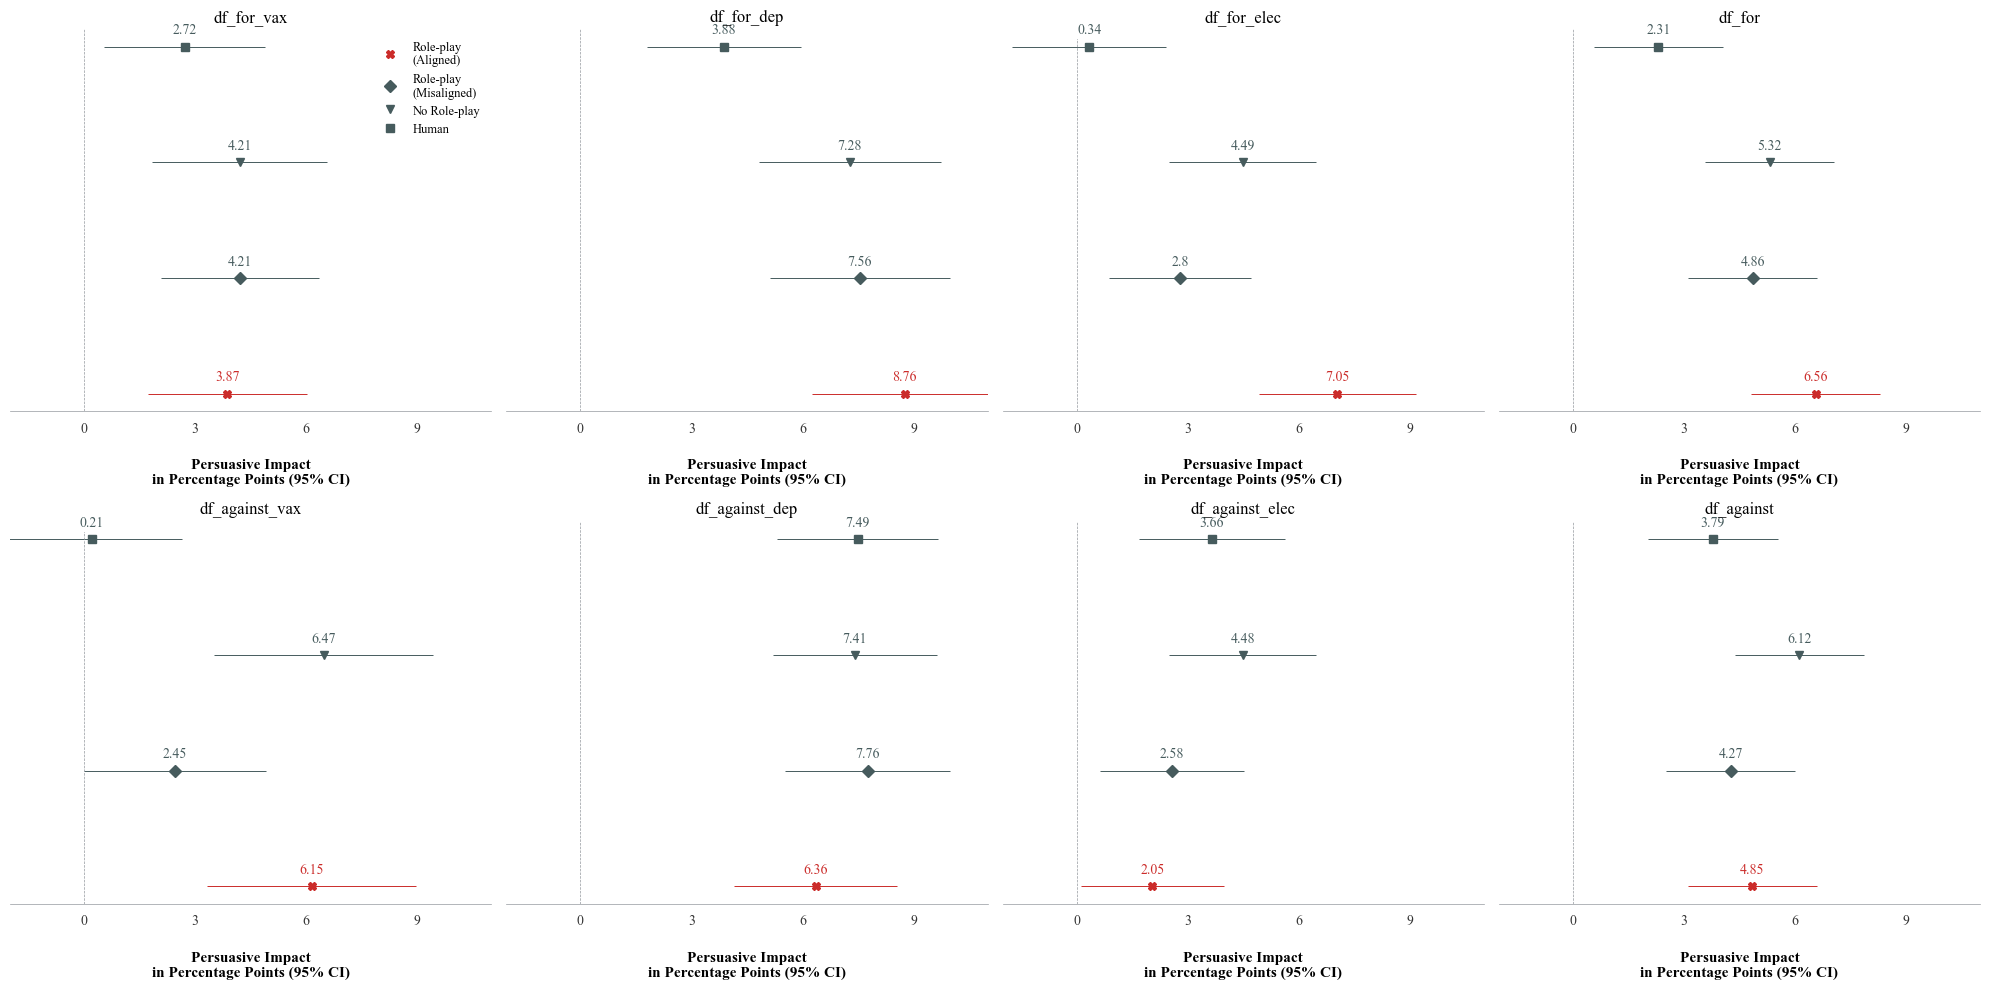

In [3]:
# Helper functions
def fit_model(formula, data, group_column):
    """Fit a model using the given formula and data."""
    model = smf.mixedlm(formula, data, groups=data[group_column])
    result = model.fit()
    return result

def fit_and_collect_results(data_sets, formula, group_column='prolific_ID'):
    """Fit models for the given datasets and collect their results."""
    results = []
    for data in data_sets:
        result = fit_model(formula, data, group_column)
        results.append(result)
    return results

# Fit models and collect results
combined_formula = "persuasion_delta ~ C(adapted_treatment, Treatment('control'))"
results_combined = fit_and_collect_results([df_for_vax, df_for_dep, df_for_elec, df_for, df_against_vax, df_against_dep, df_against_elec, df_against], combined_formula)

# Constants
COLOR_MAP = ['#CB2C2A', '#465B5D']
ISSUE_MARKER_DICT = {
    'Role-play\n(Aligned)': 'X',
    'Role-play\n(Misaligned)': 'D',
    'No Role-play': 'v',
    'Human': 's'
}
ISSUE_COLOR_DICT = {
    'Role-play\n(Aligned)': '#CB2C2A',
    'Role-play\n(Misaligned)': '#465B5D',
    'No Role-play': '#465B5D',
    'Human': '#465B5D'
}

plt.rcParams["font.family"] = "Times New Roman"
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# Order of coefficients
coef_order = [
    'Role-play\n(Aligned)',
    'Role-play\n(Misaligned)',
    'No Role-play',
    'Human'
]

# Mapping from original names to labels
rename_dict = {
    "C(adapted_treatment, Treatment('control'))[T.roleplay_misaligned]": 'Role-play\n(Misaligned)',
    "C(adapted_treatment, Treatment('control'))[T.roleplay_aligned]": 'Role-play\n(Aligned)',
    "C(adapted_treatment, Treatment('control'))[T.no_role-play]": 'No Role-play',
    "C(adapted_treatment, Treatment('control'))[T.human]": 'Human'
}

# Flatten the axs array
axs = axs.flatten()
titles = ['df_for_vax', 'df_for_dep', 'df_for_elec', 'df_for', 'df_against_vax', 'df_against_dep', 'df_against_elec', 'df_against']
for idx, (result, ax) in enumerate(zip(results_combined, axs)):
    # Add title to the subplot
    ax.set_title(titles[idx])
    
    # Drop the 'Intercept' and 'Group Var' from the parameters
    coefs = result.params.drop(['Intercept', 'Group Var'])
    
    # Get confidence intervals for the remaining coefficients
    conf_ints = result.conf_int().loc[coefs.index]

    # Rename the coefficients and the confidence intervals 
    coefs = coefs.rename(index=rename_dict)
    conf_ints = conf_ints.rename(index=rename_dict)

    # Reorder the coefficients and confidence intervals
    coefs = coefs.reindex(coef_order)
    conf_ints = conf_ints.reindex(coef_order)
    
    # Initialize the counter
    y_position = 0

    for coef_name, coef_value in coefs.items():
        lower_bound = conf_ints.loc[coef_name][0]
        upper_bound = conf_ints.loc[coef_name][1]
        color = ISSUE_COLOR_DICT[coef_name]
        marker = ISSUE_MARKER_DICT[coef_name]
        ax.errorbar(coef_value, y_position, 
                    xerr=[[coef_value - lower_bound], [upper_bound - coef_value]], 
                    fmt=marker, color=color, ecolor=color, capsize=0, lw=0.7)
        ax.text(coef_value, y_position + 0.15 , round(coef_value, 2), 
                va='center', ha='center', color=color, 
                bbox=dict(facecolor='white', edgecolor='none', pad=2.1))

        # Increment the counter
        y_position += 1

    # Visual styling
    ax.axvline(0, color='#94999E', linestyle='--', linewidth=0.5)
    ax.set_xlabel('Persuasive Impact\nin Percentage Points (95% CI)', fontsize=11, fontweight='bold', labelpad=17)
    ax.set_xlim(-2, 11)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False) 
    ax.spines['bottom'].set_color('#94999E')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.tick_params(colors='#333333')
    ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
    ax.tick_params(left=False)
    ax.tick_params(bottom=False)
    ax.yaxis.set_ticks([]) 
    ax.yaxis.set_ticklabels([]) 

# Add legend
legend_handles = [plt.Line2D([0], [0], marker=ISSUE_MARKER_DICT[key], color=ISSUE_COLOR_DICT[key], linestyle='None') 
                  for key in ISSUE_MARKER_DICT]
axs[0].legend(handles=legend_handles, labels=list(ISSUE_MARKER_DICT.keys()), loc='upper right', frameon=False, fontsize=9)

plt.tight_layout()
plt.show()

fig.savefig('figure8.pdf', format='pdf', bbox_inches='tight')